In [1]:
import numpy as np
import pickle
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
import sys
sys.path.append("../chembl_analyser/module/")
from calcula_tanimoto import *

In [3]:
from ddc_pub import ddc_v3 as ddc

In [4]:
import molvecgen

In [5]:
model_name = "models/pcb_model"
model = ddc.DDC(model_name=model_name)

Initializing model in test mode.
Loading model.
'mol_to_latent_model' not found, setting to None.


/home/alverad/anaconda3/envs/ddc_env/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loading finished in 3 seconds.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Latent_Input (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     [(None, 142, 35)]    0                                            
__________________________________________________________________________________________________
latent_to_states_model (Model)  [(None, 256), (None, 18432       Latent_Input[0][0]               
__________________________________________________________________________________________________
batch_model (Model)             (None, 142, 35)      1364771     Decoder_Inputs[0][0]             
                                                               

In [6]:
qsar_model_name = "models/qsar_model.pickle"
with open(qsar_model_name, "rb") as file:
    qsar_model = pickle.load(file)["classifier_sv"]

/home/alverad/anaconda3/envs/ddc_env/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, QED
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
#We suppres stdout from invalid smiles and validations
from rdkit import rdBase
rdBase.DisableLog ( 'rdApp.*')

In [8]:
def get_descriptors(mol):
    logp  = Descriptors.MolLogP(mol)
    tpsa  = Descriptors.TPSA(mol)
    molwt = Descriptors.ExactMolWt(mol)
    hba   = rdMolDescriptors.CalcNumHBA(mol)
    hbd   = rdMolDescriptors.CalcNumHBD(mol)
    qed   = QED.qed(mol)
     
                     
    # Calculate fingerprints
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=2048)
    ecfp4 = np.zeros((2048,))
    DataStructs.ConvertToNumpyArray(fp, ecfp4) 
    # Predict activity and pick only the second component
    active_probability = qsar_model.predict_proba([ecfp4])[0][1]
    return [logp, tpsa, molwt, qed, hba, hbd, active_probability]

In [9]:
cruzain = pd.read_csv("chembl_smiles.csv")

In [10]:
cruzain = cruzain[['Molecule ChEMBL ID', 'Smiles']]

In [11]:
lista = []
for chembl, smiles in cruzain.to_numpy().tolist():
    lista.append([chembl, smiles] + get_descriptors(Chem.MolFromSmiles(smiles)))

In [12]:
data_cru_pro = pd.DataFrame(lista, columns=['chembl', 'smiles', "logp", "tpsa", "molwt", "qed", "hba", "hbd", "active_probability"])

In [13]:
data_cru_pro.sort_values(by='active_probability', ascending=False)

,chembl,smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability
562,CHEMBL4095194,c1c[nH]c(CN2CCc3ccccc3C2)c1,2.57300,19.03000,212.13135,0.81030,1,1,0.71309
88,CHEMBL3233099,Cc1ccccc1OCCNCCc1nc2ccccc2[nH]1,3.08242,49.94000,295.16846,0.65859,3,2,0.39986
541,CHEMBL4068608,CN1CCN(Cc2ccc[nH]2)CC1,0.76210,22.27000,179.14225,0.72391,2,1,0.35635
359,CHEMBL3623846,O=P(O)(O)[C@H](NC[C@@H]1CCCc2ccccc21)c1ccc(F)cc1,3.71170,69.56000,349.12431,0.71995,2,3,0.25387
366,CHEMBL3291070,COc1cc(O)cc2c1[C@@H](/C=C/c1ccc(O)cc1)[C@@H]1[...,6.50120,97.61000,524.18350,0.27412,7,3,0.11433
...,...,...,...,...,...,...,...,...,...
669,CHEMBL4082855,O=C(CNc1ccnc2cc(Cl)ccc12)N1CCOCC1,2.15890,54.46000,305.09310,0.94395,4,1,0.00000
247,CHEMBL3233108,Cc1ccccc1OCC(=O)NCCC(=O)Nc1ccccc1O,2.22442,87.66000,328.14231,0.68020,4,3,0.00000
334,CHEMBL3233106,Cc1ccccc1OCC(=O)NCCC(=O)Nc1ccccc1,2.51882,67.43000,312.14739,0.82530,3,2,0.00000
498,CHEMBL3104699,O=C1/C(=C/c2ccnc3ccccc23)CCC/C1=C\c1ccnc2ccccc12,6.00300,42.85000,376.15756,0.40282,3,0,0.00000


In [14]:
data_cru_pro.loc[data_cru_pro.smiles.str.contains('#')]

,chembl,smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability
10,CHEMBL344174,N#CCNC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccccc1,2.16388,91.22000,337.14264,0.75756,4,2,0.00008
209,CHEMBL604281,CN(C#N)N(C)C(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccccc1,2.31038,85.67000,366.16919,0.46167,5,1,0.00029
361,CHEMBL3233104,Cc1cc(C)c(C#N)c(SCCNC(=O)COc2ccccc2C)n1,3.16584,75.01000,355.13545,0.60982,5,1,0.00005
411,CHEMBL6966,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,5.09308,63.95000,454.28316,0.41990,6,0,0.00987
483,CHEMBL4217658,N#CC1(NC(=O)[C@H](Cc2ccccc2)NC(=O)OCc2ccccc2)CC1,2.69648,91.22000,363.15829,0.79117,4,2,0.00027
484,CHEMBL4212454,CN(C#N)N(C)C(=O)[C@H](Cc1ccccc1)NC(=O)c1cc(C(C...,1.84498,94.26000,396.22737,0.45679,6,1,0.00078
554,CHEMBL3233084,N#Cc1ccccc1OCC(=O)NCCc1nc2ccccc2[nH]1,2.17228,90.80000,320.12733,0.72803,4,2,0.00109
581,CHEMBL4217414,CC(C)C[C@H](NC(=O)c1cc(C(C)(C)C)nn1C)C(=O)N(C)...,1.64838,94.26000,362.24302,0.47164,6,1,0.00082
682,CHEMBL4212989,CC(C)C[C@H](NC(=O)OC(C)(C)C)C(=O)N(C)N(C)C#N,1.71208,85.67000,298.20049,0.47424,5,1,0.00036


In [15]:
smiles_target = "CC(C)(F)C[C@H](N[C@@H](c1ccc(-c2ccc(S(C)(=O)=O)cc2)cc1)C(F)(F)F)C(=O)NC1(C#N)CC1"

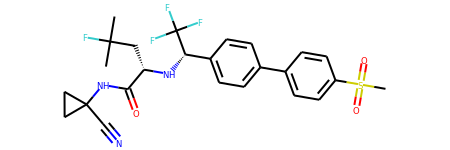

[4.629280000000003,
 99.06,
 525.170925604,
 0.46543875908402327,
 5,
 2,
 0.002105118497304605]

In [16]:
mol = Chem.MolFromSmiles(smiles_target)
display(mol)
conditions = get_descriptors(mol)
conditions

In [17]:
target = np.array(conditions)
#smiles_out, _ = model.predict(latent=target, temp=1)
#Chem.MolFromSmiles(smiles_out)

In [18]:
#model.batch_input_length = 256
smiles_out = []
for i in range(100):
    smiles, _ = model.predict_batch(latent=target.reshape(1,-1), temp=1.0)
    smiles_out.append(smiles)
smiles_out = np.concatenate(smiles_out)
smiles_out.shape

/home/alverad/notebooks/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebooks/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebooks/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebooks/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebooks/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebooks/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebooks/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered

(25600,)

In [19]:
mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]

In [20]:
def sanitize(mol):
    try:
        Chem.SanitizeMol(mol)
        return mol
    except Exception as e:
        print(e)
         
sani_mols = [sanitize(mol) for mol in mols if mol != None]

Sanitization error: Explicit valence for atom # 17 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 29 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 35 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 32 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 34 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 35 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 37 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 34 O, 3, is greater than permitted


In [21]:
len(sani_mols)

22514

In [22]:
len(sani_mols)/len(smiles_out)

0.879453125

In [23]:
properties = [[Chem.MolToSmiles(mol)] + get_descriptors(mol) for mol in sani_mols if mol != None]
import pandas as pd
target_names = ["Smiles", "logp", "tpsa", "molwt", "qed", "hba", "hbd", "active_probability"]
data = pd.DataFrame(properties, columns=target_names)

In [24]:
data.sort_values(by='active_probability', ascending=False)

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability
13897,COc1cccc(C(=O)NCC2CCN(C(=O)C3CCCC3c3ccc(C)cc3)...,4.83832,92.89000,517.25767,0.46801,5,2,0.82776
1327,CCC(CO)N1CC(C)N(C2CCc3c(-c4cccc(C(N)=O)c4)cccc...,4.11010,103.94000,519.21918,0.51016,5,2,0.76203
19570,Cc1cc(-c2ccc(CN3CCC(n4c(=O)c5ccccc5n(CC(O)C(C)...,4.10582,96.15000,515.28964,0.40303,7,2,0.69802
16838,Cc1ccc(OCCF)c(C2C(NS(=O)(=O)c3ccc(C)c(Cl)c3)CC...,4.82304,96.97000,532.17112,0.45436,5,2,0.68481
13437,CCN1CCc2cc(Cl)cc(C(=O)NC3CCN(c4oc(-c5ccc(F)cc5...,4.74510,103.09000,525.14668,0.48145,5,2,0.64634
...,...,...,...,...,...,...,...,...
5725,O=C(O)c1ccc(S(=O)(=O)Nc2ccc(C(c3ccccc3)(N3CCOC...,4.32370,95.94000,520.12798,0.48184,5,2,0.00001
10129,CCOC(=O)N1CCN(C(=O)c2ccc(NC(=O)c3cccc(C(=S)Nc4...,4.94922,90.98000,530.19878,0.43855,5,2,0.00001
15970,O=C(NC(CC(=O)N1CCOCC1)C(=O)Nc1ccc(Cl)cc1F)c1cc...,4.25740,96.97000,525.14668,0.45796,5,2,0.00001
752,CCC(NC(=O)O)c1cc(C)c2c(ncn2S(=O)(=O)c2cccc(Br)...,4.82542,101.29000,528.93065,0.49182,5,2,0.00001


In [25]:
len(data)

22506

In [26]:
len(data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False))

1748

In [27]:
data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False)

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability
1960,CCc1ncnc(-c2cc(C(C)(C)C)cc(N3CCN(CC4CC4)C3=O)c...,4.87147,98.20000,524.28997,0.44962,5,2,0.39225
4427,COC(=O)NC(Cc1ccccc1)C(Cc1ccc(Cl)cc1)NC(CC(C)C)...,4.73728,94.46000,524.25542,0.44262,5,2,0.31431
6409,N#Cc1ccc(-n2[nH]c(-c3ccccc3Cl)c(C(=O)NCCN3CCCC...,5.05648,89.21000,516.24044,0.45987,5,2,0.30752
7462,COc1cccc2c1Cc1ccccc1CC2C(=O)NC(Cc1ccccc1)C(=O)...,3.84058,100.45000,523.24711,0.46739,5,2,0.30162
16338,C=CC(C)N1CCCC1CNC(=O)c1ccc(S(=O)Nc2cc(Cl)c(OC)...,4.77708,94.46000,520.11027,0.46368,5,2,0.29325
...,...,...,...,...,...,...,...,...
16677,CCc1cc(F)cc(C)c1NC(=O)c1cnc2c(C(=NC#N)N3CC(C)C...,4.95960,98.68000,539.14445,0.21842,6,1,0.00007
19479,N#Cc1c(CNc2ccccc2)cc(NC(=O)c2cccc(S(=O)(=O)N3C...,4.46238,111.53000,544.13921,0.45441,6,2,0.00006
22,CCC1c2c(c(O)n(Cc3ccccc3)c2O)C(Cc2cc(Cl)cc(Br)c...,5.50668,89.49000,527.06113,0.41313,5,2,0.00006
20293,CC(CC#N)CC(O)CC(=O)NC1(Cc2ccc(-c3ccc(C(F)(F)F)...,5.18628,99.42000,516.22359,0.44733,5,2,0.00005


In [28]:
data_com_tanimoto = calcula_tanimoto(smiles_target, data, 4)

In [29]:
data_com_tanimoto.loc[(data_com_tanimoto.i_tanimoto > 0.2) & (data_com_tanimoto.active_probability > 0.2) & (data_com_tanimoto.Smiles.str.contains("#"))]

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability,i_tanimoto
1199,COC(=O)NC(Cc1ccccc1)C(Cc1ccc(Cl)cc1)NC(CC(C)C)...,4.73728,94.46000,524.25542,0.44262,5,2,0.31431,0.42000
3339,COCC#Cc1nc2cccc(Cl)c2c(N(C)c2ccc(F)cc2)c1C(=O)...,4.56700,97.55000,522.18340,0.46224,5,2,0.27613,0.39000
3666,CCc1ncnc(-c2cc(C(C)(C)C)cc(N3CCN(CC4CC4)C3=O)c...,4.87147,98.20000,524.28997,0.44962,5,2,0.39225,0.38000
5542,CCC1CCN(C(=O)C(CCCC2CCNCC2)NC(=O)c2cc(-c3cccc(...,4.41778,102.30000,518.26932,0.51180,5,2,0.21387,0.44000
2563,C#CC1C(CC)NCCN1C(=O)c1cc(-c2cccc(Oc3ccccc3)c2)...,4.74710,96.02000,524.24236,0.43524,5,2,0.25331,0.40000
470,CCC(C)(CC(C)CN1CC1)C1CC(F)(F)CCC1NC(Cc1ccccc1)...,4.47168,96.94000,538.32317,0.41167,5,2,0.26002,0.36000
541,C=CC(C)N1CCCC1CNC(=O)c1ccc(S(=O)Nc2cc(Cl)c(OC)...,4.77708,94.46000,520.11027,0.46368,5,2,0.29325,0.37000
3346,C#CCOc1ccc(C2CCN(C(=O)c3cccnc3C(=O)Nc3cccc(CN)...,4.84320,97.55000,536.20353,0.42134,5,2,0.27925,0.34000
4563,COc1cc(N2CCN(C(=S)CCCc3nc(=Nc4cc5ccccc5[nH]4)[...,5.08688,96.33000,531.16081,0.32253,6,2,0.20389,0.31000
5100,COc1cc(C#CCNC(=O)C(C)NC(=O)c2ccc(C(C)C)cc2)ccc...,4.55000,93.73000,518.27807,0.39508,5,2,0.24586,0.36000


In [48]:
data_com_tanimoto.loc[(data_com_tanimoto.i_tanimoto > 0.4) & (data_com_tanimoto.active_probability > 0.2)]

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability,i_tanimoto
1189,CC=CC(=O)N1C(=CC(O)CC(NC(=O)OCC)C(=O)N2CCCC2c2...,4.58610,99.18000,531.25000,0.47807,5,2,0.22043,0.42000
1199,COC(=O)NC(Cc1ccccc1)C(Cc1ccc(Cl)cc1)NC(CC(C)C)...,4.73728,94.46000,524.25542,0.44262,5,2,0.31431,0.42000
1204,COc1ccc(C(CC(=O)O)C(C=O)C(=O)N2CCC3CCc4c(-c5cc...,4.76390,104.14000,527.23079,0.30711,5,2,0.26015,0.41000
4299,CCC(CO)N1CC(C)N(C2CCc3c(-c4cccc(C(N)=O)c4)cccc...,4.11010,103.94000,519.21918,0.51016,5,2,0.76203,0.42000
5542,CCC1CCN(C(=O)C(CCCC2CCNCC2)NC(=O)c2cc(-c3cccc(...,4.41778,102.30000,518.26932,0.51180,5,2,0.21387,0.44000
2126,COc1c(C(=O)NC2CC2)cc(S(=O)(=O)NC(=O)c2ccccc2Cl...,4.30470,101.57000,520.06713,0.48336,5,2,0.21633,0.41000
2904,COc1cccc(-c2c(N)ccc3c2OCC(CCC(=O)NC2(c4ccccc4)...,4.92970,93.89000,527.27841,0.42518,5,2,0.31291,0.43000
2517,COc1ccc(-c2ccccc2Cl)cc1C1CCN1CCC(=O)C(=O)NC(CC...,4.53110,87.74000,525.23943,0.39744,5,2,0.26747,0.47000
794,CS(=O)(=O)CCC(NC(=O)Oc1ccccc1Cl)C(=O)NC1c2cccc...,4.40130,101.57000,524.15480,0.42414,5,2,0.24894,0.42000
1712,O=C(CCC(NC(=O)c1cc2ccccc2o1)C(=O)N1CCC2CCCCC21...,4.35380,100.88000,529.25767,0.45185,5,2,0.23404,0.42000


In [40]:
alvos_cruzain = data_com_tanimoto.loc[(data_com_tanimoto.i_tanimoto > 0.3) & (data_com_tanimoto.active_probability > 0.2) & (data_com_tanimoto.Smiles.str.contains("#"))]
alvos_cruzain

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability,i_tanimoto
1199,COC(=O)NC(Cc1ccccc1)C(Cc1ccc(Cl)cc1)NC(CC(C)C)...,4.73728,94.46000,524.25542,0.44262,5,2,0.31431,0.42000
3339,COCC#Cc1nc2cccc(Cl)c2c(N(C)c2ccc(F)cc2)c1C(=O)...,4.56700,97.55000,522.18340,0.46224,5,2,0.27613,0.39000
3666,CCc1ncnc(-c2cc(C(C)(C)C)cc(N3CCN(CC4CC4)C3=O)c...,4.87147,98.20000,524.28997,0.44962,5,2,0.39225,0.38000
5542,CCC1CCN(C(=O)C(CCCC2CCNCC2)NC(=O)c2cc(-c3cccc(...,4.41778,102.30000,518.26932,0.51180,5,2,0.21387,0.44000
2563,C#CC1C(CC)NCCN1C(=O)c1cc(-c2cccc(Oc3ccccc3)c2)...,4.74710,96.02000,524.24236,0.43524,5,2,0.25331,0.40000
470,CCC(C)(CC(C)CN1CC1)C1CC(F)(F)CCC1NC(Cc1ccccc1)...,4.47168,96.94000,538.32317,0.41167,5,2,0.26002,0.36000
541,C=CC(C)N1CCCC1CNC(=O)c1ccc(S(=O)Nc2cc(Cl)c(OC)...,4.77708,94.46000,520.11027,0.46368,5,2,0.29325,0.37000
3346,C#CCOc1ccc(C2CCN(C(=O)c3cccnc3C(=O)Nc3cccc(CN)...,4.84320,97.55000,536.20353,0.42134,5,2,0.27925,0.34000
4563,COc1cc(N2CCN(C(=S)CCCc3nc(=Nc4cc5ccccc5[nH]4)[...,5.08688,96.33000,531.16081,0.32253,6,2,0.20389,0.31000
5100,COc1cc(C#CCNC(=O)C(C)NC(=O)c2ccc(C(C)C)cc2)ccc...,4.55000,93.73000,518.27807,0.39508,5,2,0.24586,0.36000


In [41]:
smiles = alvos_cruzain.Smiles
prob = alvos_cruzain.active_probability
tani = alvos_cruzain.i_tanimoto

In [42]:
smiles = smiles.to_numpy().tolist()
prob = [f"{prob*100:0.2f}%" for prob in prob.to_numpy().tolist()]
tani = [f"{tani*100:0.2f}%" for tani in tani.to_numpy().tolist()]

In [43]:
mols = [Chem.MolFromSmiles(smile) for smile in smiles]

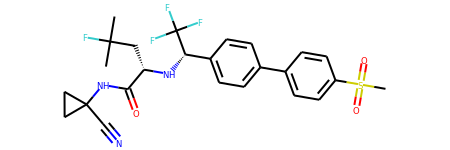

In [44]:
mol

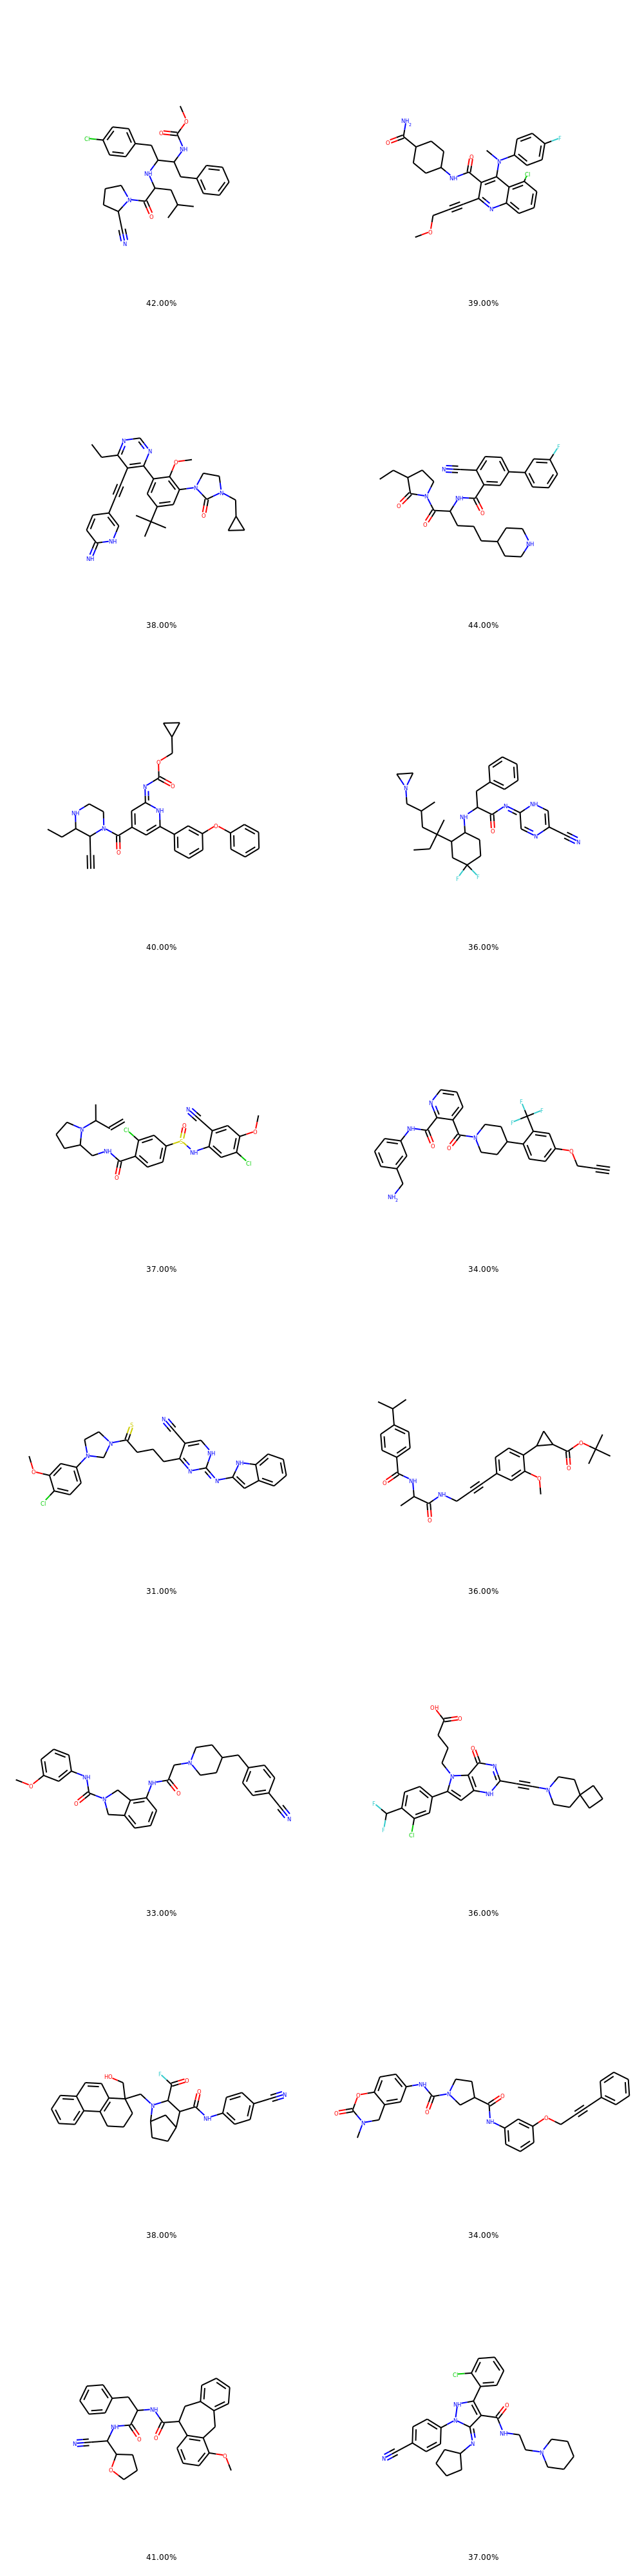

In [50]:
Chem.Draw.MolsToGridImage(mols, legends=tani,molsPerRow=2,subImgSize=(500,500))

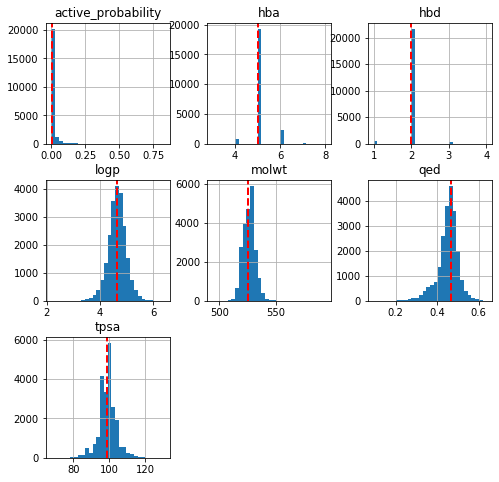

In [51]:
target_dict = {t[0]:t[1] for t in zip(data.columns, [smiles_target] + conditions)}
axes = data.hist(bins=30,figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    title = ax.title.__dict__["_text"]
    if title:
        ax.axvline(x=target_dict[title], color='r', linestyle='dashed', linewidth=2)

In [37]:
import sqlite3

In [52]:
con_ligs = sqlite3.connect("../chembl_analyser/data/ligantes_odn.db")

In [53]:
data_com_tanimoto.to_sql("novos_ligantes", con_ligs, index=False, if_exists="replace")

In [55]:
con = sqlite3.connect("../chembl_analyser/data/propriedades.db")

In [56]:
data_2 = pd.read_sql("select * from dados", con)

In [58]:
data_2

,chembl_id,mw_freebase,alogp,psa,rtb,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,canonical_smiles
0,CHEMBL287510,357.45400,1.51190,73.83000,10.00000,nan,8.79000,1.80000,0.40000,BASE,357.45000,2.00000,26.00000,0.56000,357.20520,5.00000,3.00000,0.00000,CN(C)c1ccccc1C(=O)NCCNCC(O)COc1ccccc1
1,CHEMBL285301,320.43300,1.71240,70.59000,9.00000,nan,8.79000,1.96000,0.55000,BASE,320.43000,2.00000,23.00000,0.61000,320.21000,4.00000,3.00000,0.00000,O=C(NCCNCC(O)COc1ccccc1)C1CCCCC1
2,CHEMBL285413,255.31400,1.41230,48.95000,8.00000,nan,7.42000,1.45000,1.14000,NEUTRAL,255.31000,1.00000,18.00000,0.71000,255.14710,5.00000,1.00000,0.00000,COc1ccc(OC)c(CNCC(OC)OC)c1
3,CHEMBL24475,262.34900,3.64890,46.53000,8.00000,9.95000,nan,4.40000,4.40000,NEUTRAL,262.35000,1.00000,19.00000,0.57000,262.15690,3.00000,1.00000,0.00000,CCCC/C=C/C(=O)CCc1ccc(O)c(OC)c1
4,CHEMBL24545,330.46800,4.45000,43.37000,2.00000,nan,nan,4.21000,4.21000,NEUTRAL,330.47000,4.00000,24.00000,0.70000,330.21950,3.00000,0.00000,0.00000,CCC(=O)OC1CCC2C3CCC4=CC(=O)CCC4C3CCC12C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2084583,CHEMBL4110107,507.53800,4.47270,105.57000,8.00000,11.72000,3.32000,3.13000,3.13000,NEUTRAL,507.54000,4.00000,35.00000,0.47000,507.15520,7.00000,2.00000,1.00000,Cc1cc(N=S2(=O)CCC2)cc2ncnc(Nc3ccc(F)cc3O[C@H](...
2084584,CHEMBL4110108,337.33500,3.03200,76.68000,2.00000,11.84000,5.74000,2.11000,2.10000,NEUTRAL,337.34000,5.00000,25.00000,0.78000,337.10630,5.00000,1.00000,0.00000,O=C1OC[C@H](c2ccc3c(c2)OCCO3)N1c1ccc2nc[nH]c2c1
2084585,CHEMBL4110109,338.78500,4.11530,41.99000,7.00000,nan,7.09000,3.66000,3.49000,NEUTRAL,338.79000,2.00000,23.00000,0.77000,338.09970,3.00000,1.00000,0.00000,CC[C@@H](NCCF)c1ccc(Cl)c(C(=O)c2cccnc2)c1F
2084586,CHEMBL4110110,480.96800,3.12660,96.81000,10.00000,nan,3.97000,3.19000,3.19000,NEUTRAL,480.97000,3.00000,33.00000,0.54000,480.19400,7.00000,2.00000,0.00000,CC(C(=O)NCCF)c1ccc(O[C@@H]2CCN(c3ncnc(OCC(C)(C...


In [59]:
data_2.query("canonical_smiles in @data_com_tanimoto.Smiles")

,chembl_id,mw_freebase,alogp,psa,rtb,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,canonical_smiles
